# Autoencoder Training using best parameters

In [2]:
import pandas as pd #reading dataset
import matplotlib as mpl    #plotting, visualization
import matplotlib.pyplot as plt
import tensorflow as tf #building model
from tensorflow.keras.models import Model
import numpy as np  #playing output with model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import json

import sys
sys.path.append('../../../')   # Add parent directory to Python path
from utils.Plots import *


In [3]:
df = pd.read_csv('../../../data/handlebar/train_data.csv') 
df


,curb_scene,Acc-Z_1,Acc-Z_2,Acc-Z_3,Acc-Z_4,Acc-Z_5,Acc-Z_6,Acc-Z_7,Acc-Z_8,Acc-Z_9,...,Acc-Z_91,Acc-Z_92,Acc-Z_93,Acc-Z_94,Acc-Z_95,Acc-Z_96,Acc-Z_97,Acc-Z_98,Acc-Z_99,Acc-Z_100
0,0.0,9.595963,11.133041,4.472366,4.592072,5.310333,17.501617,17.319656,11.291061,1.508347,...,12.737152,5.166687,1.039078,4.481949,12.052414,14.475342,10.692505,5.358231,9.576813,11.377243
1,0.0,10.783478,6.344635,7.445969,5.238510,13.091492,11.386826,10.783478,11.496963,6.526596,...,1.403000,5.516235,14.652512,20.005950,19.383453,8.058884,-1.537079,1.977615,7.565674,12.028473
2,0.0,3.337524,7.517792,9.902420,10.031708,8.283936,4.472366,3.035843,3.643982,7.814682,...,14.216766,7.493851,5.602432,4.893753,6.569687,9.054871,15.021225,13.584702,7.206543,3.801987
3,0.0,18.243820,16.591812,5.564117,0.545883,5.013458,14.211975,14.006073,8.705322,2.978394,...,11.310211,-10.534485,16.476898,21.538239,-7.268799,-34.404680,-28.218063,5.147537,11.401184,-16.716324
4,0.0,4.596863,6.186615,15.246277,13.919891,8.963898,2.796432,6.962341,13.867218,13.541611,...,14.494492,3.821152,-0.531509,0.780502,14.202408,24.056946,18.804062,7.503433,4.218582,7.766785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7448,0.0,11.846512,12.756302,10.113113,3.821152,2.154785,4.836289,-0.900223,8.734055,6.368576,...,7.220917,8.556885,5.674255,13.450623,12.866440,11.535263,9.323029,9.375702,12.971787,10.429138
7449,0.0,8.657440,8.633499,8.652649,8.609543,8.633499,8.638275,8.647858,8.623917,8.619125,...,8.643066,8.647858,8.643066,8.633499,8.647858,8.643066,8.633499,8.619125,8.647858,8.633499
7450,0.0,8.643066,8.647858,8.633499,8.638275,8.643066,8.638275,8.633499,8.638275,8.643066,...,8.643066,8.623917,8.652649,8.633499,8.633499,8.652649,8.647858,8.652649,8.633499,8.647858
7451,0.0,8.015793,7.814682,4.362228,8.906433,12.660538,13.761871,10.079590,8.599976,5.415680,...,11.520905,22.045807,16.041153,6.971909,-0.167587,5.171478,11.343735,21.327545,9.629486,-5.104431


In [4]:
#scaling data, because neural network works better with scaled data
scaler = StandardScaler()
data_scaled = scaler.fit(df.iloc[:, 1:])
#transform data
train_data_scaled = scaler.transform(df.iloc[:, 1:])



In [5]:
# Convert the scaled data back to DataFrames for further processing
train_data_scaled_df = pd.DataFrame(train_data_scaled, columns=df.columns[1:])
train_data_scaled_df['curb_scene'] = df['curb_scene'].values
train_data_scaled_df.shape

(7453, 101)

In [6]:
# Filter and slice the data
normal_train_data_scaled = train_data_scaled_df[train_data_scaled_df['curb_scene'] == 0.0].iloc[:, :-1]
abnormal_train_data_scaled = train_data_scaled_df[train_data_scaled_df['curb_scene'] == 1.0].iloc[:, :-1]
normal_train_data_scaled.shape,abnormal_train_data_scaled.shape

((7178, 100), (275, 100))

In [7]:
# Cast to float32
normal_train_data_scaled = normal_train_data_scaled.astype("float32")
abnormal_train_data_scaled = abnormal_train_data_scaled.astype("float32")

In [8]:
from keras.models import Sequential
from keras.layers import Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import Model

# Define the autoencoder model using Sequential API
model = Sequential([
    # Encoder layers
    Input(shape=(100,)),  # Input shape based on your data
    Dense(256, activation='tanh'),
    Dense(224, activation='tanh'),
    Dense(160, activation='tanh'),
    
    # Decoder layers
    Dense(160, activation='tanh'),
    Dense(224, activation='tanh'),
    Dense(256, activation='tanh'),
    Dense(100, activation='tanh')  # Output shape matches input shape
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mae')

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 224)            │        57,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 160)            │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 160)            │        25,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 224)            │        36,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        57,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,548 (1.01 MB)

 Trainable params: 264,548 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
## Compile the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mae')

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 224)            │        57,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 160)            │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 160)            │        25,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 224)            │        36,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        57,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,548 (1.01 MB)

 Trainable params: 264,548 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# seprate class as well for normal and abnormal data invalidation data
history = model.fit(normal_train_data_scaled, 
                    normal_train_data_scaled,
                    epochs=200, 
                    batch_size=512,
                    validation_split=0.3, 
                    shuffle=True, 
                    callbacks=[early_stopping])

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.4916 - val_loss: 0.4523
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4520 - val_loss: 0.4233
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4249 - val_loss: 0.3995
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4021 - val_loss: 0.3802
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3796 - val_loss: 0.3648
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3684 - val_loss: 0.3527
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3591 - val_loss: 0.3426
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3458 - val_loss: 0.3338
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3341 - val_loss: 0.3260
Epoch 10/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3325 - val_loss: 0.3188
Epoch 11/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3243 - val_loss: 0.3123
Epoch 12/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

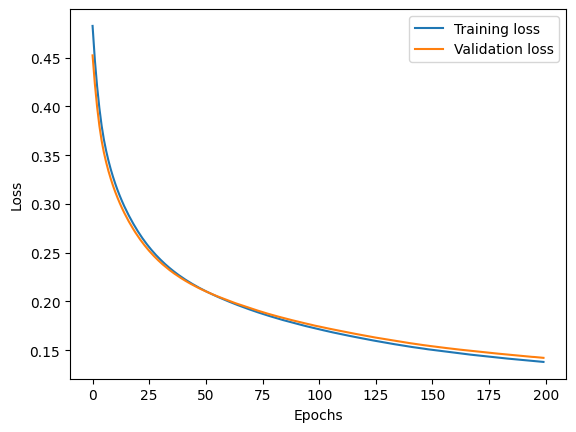

In [14]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [16]:
from keras import ops
model.save('../../../models/autoencoder_best.keras')

In [17]:
load_model = tf.keras.models.load_model('../../../models/autoencoder_best.keras')

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


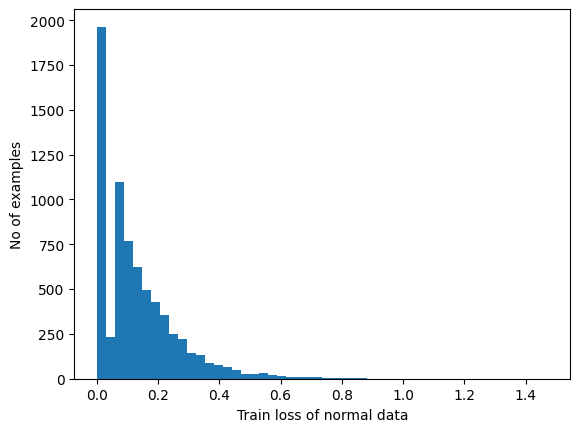

In [18]:
#Plot the reconstruction error on normal data from the training set
reconstructions_normal = load_model.predict(normal_train_data_scaled)
train_loss_normal = tf.keras.losses.mae(reconstructions_normal, normal_train_data_scaled)

plt.hist(train_loss_normal[None,:], bins=50)
plt.xlabel("Train loss of normal data")
plt.ylabel("No of examples")
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


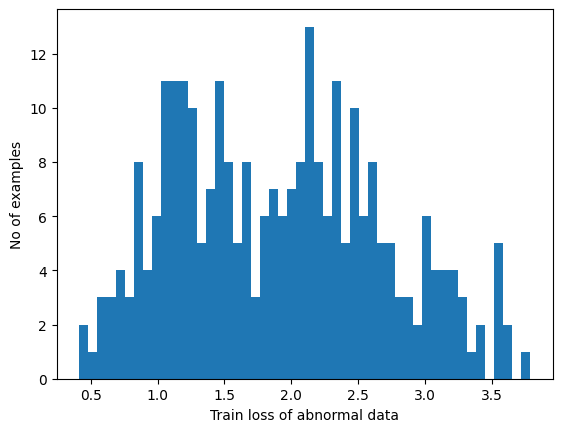

Min value: 0.41668978


In [19]:
#Plot the reconstruction error on abnormal data from the training set
reconstructions_abnormal = load_model.predict(abnormal_train_data_scaled)
train_loss_abnormal = tf.keras.losses.mae(reconstructions_abnormal, abnormal_train_data_scaled)

plt.hist(train_loss_abnormal[None,:], bins=50)
plt.xlabel("Train loss of abnormal data")
plt.ylabel("No of examples")
plt.show()

print("Min value:", tf.reduce_min(train_loss_abnormal).numpy())


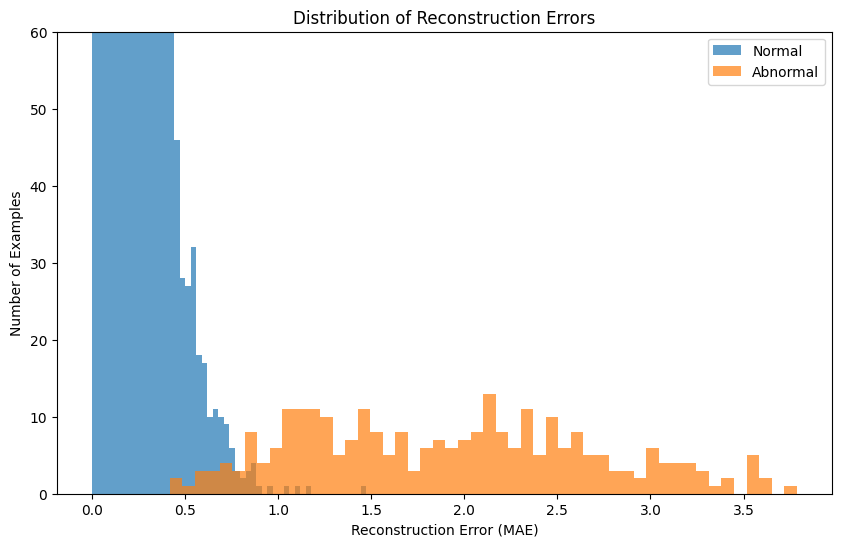

In [20]:
# Visualize threshold with histogram
plt.figure(figsize=(10, 6))
plt.hist(train_loss_normal, bins=50, alpha=0.7, label='Normal')
plt.hist(train_loss_abnormal, bins=50, alpha=0.7, label='Abnormal')
plt.ylim(0, 60)
#plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label=f'Threshold: {threshold:.4f}')
plt.xlabel('Reconstruction Error (MAE)')
plt.ylabel('Number of Examples')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.show()

In [21]:
# Calculate thresholds
high_threshold = np.percentile(train_loss_normal, 99.99)  # Loose threshold (99th percentile)
print("High threshold: ", high_threshold)

High threshold:  1.2413487


In [22]:
# Function to calculate precision, recall, and F1 score
def calculate_metrics(threshold, normal_losses, abnormal_losses):
    # Convert TensorFlow tensors to NumPy arrays
    normal_losses = normal_losses.numpy()
    abnormal_losses = abnormal_losses.numpy()
    
    predictions_normal = (normal_losses > threshold).astype(int)
    predictions_abnormal = (abnormal_losses > threshold).astype(int)
    
    tp = np.sum(predictions_abnormal == 1)
    fp = np.sum(predictions_normal == 1)
    fn = np.sum(predictions_abnormal == 0)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

In [23]:
# Generate threshold values based on the range of your loss values
min_loss = min(np.min(train_loss_normal.numpy()), np.min(train_loss_abnormal.numpy()))
max_loss = max(np.max(train_loss_normal.numpy()), np.max(train_loss_abnormal.numpy()))
thresholds = np.linspace(min_loss, max_loss, 100)

# Calculate metrics for each threshold
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    precision, recall, f1 = calculate_metrics(threshold, train_loss_normal, train_loss_abnormal)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Find the best F1 score and its threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]



In [24]:
np.min(train_loss_abnormal.numpy())

np.float32(0.41668978)

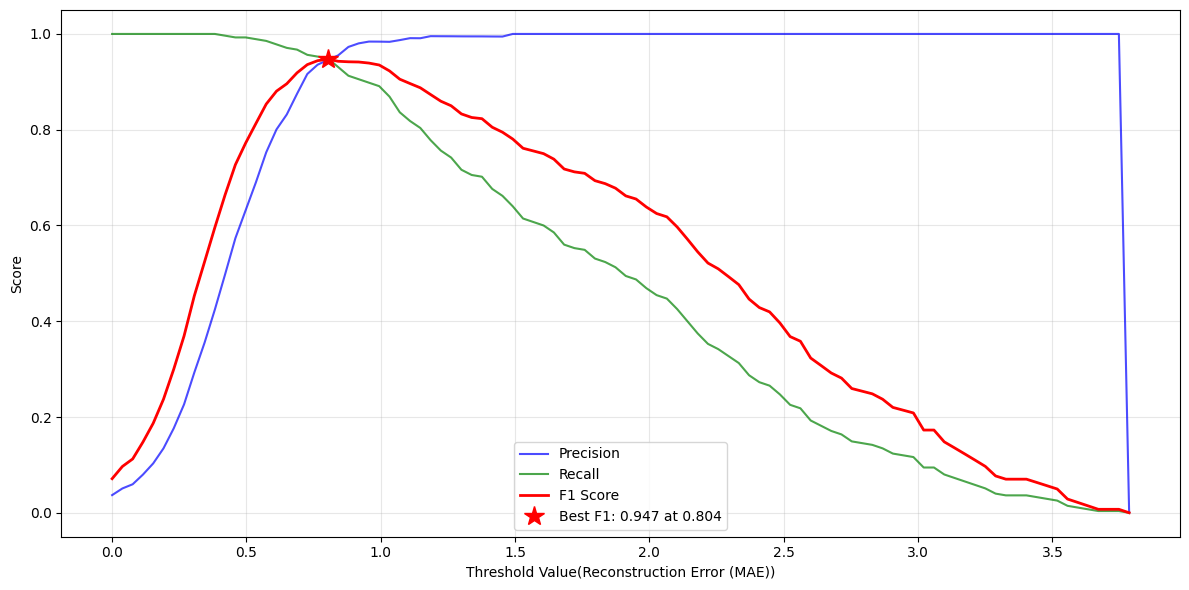

Optimal threshold (best F1 score): 0.8037
Best F1 score: 0.9474


In [25]:
plt.figure(figsize=(12, 6))

# Plot metrics
plt.plot(thresholds, precisions, 'b-', label='Precision', alpha=0.7)
plt.plot(thresholds, recalls, 'g-', label='Recall', alpha=0.7)
plt.plot(thresholds, f1_scores, 'r-', label='F1 Score', linewidth=2)

# Mark the best F1 score
plt.plot(best_threshold, best_f1, 'r*', markersize=15, 
         label=f'Best F1: {best_f1:.3f} at {best_threshold:.3f}')

# Customize the plot
plt.xlabel('Threshold Value(Reconstruction Error (MAE))')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print the optimal threshold
print(f"Optimal threshold (best F1 score): {best_threshold:.4f}")
print(f"Best F1 score: {best_f1:.4f}")

In [2]:
best_threshold = 0.81
high_threshold = 1.27
low_threshold = 0.39

In [3]:

# Save threshold to a JSON file
threshold_data = {
    'low_threshold': float(low_threshold),  # Convert to native Python float
    'middle_threshold': float(best_threshold),  # Convert numpy.float32 to native Python float
    'high_threshold': float(high_threshold),  # Convert numpy.float32 to native Python float
}
# Save in the same directory as the model
with open('../../../models/autoencoder_thresholds.json', 'w') as f:
    json.dump(threshold_data, f)


In [4]:
# Verify the saved data
with open('../../../models/autoencoder_thresholds.json', 'r') as f:
    loaded_thresholds = json.load(f)
print("Saved thresholds:", loaded_thresholds)

Saved thresholds: {'low_threshold': 0.39, 'middle_threshold': 0.81, 'high_threshold': 1.27}
